# Import Libraries

In [297]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import random
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose

# Load Data

In [298]:
hotel_information = pd.read_csv('./hotels_information.csv')

In [299]:
hotel_information.head()

,our_hotel_id,name,review_score,stars,latitude,longitude,room_count
0,3169410,Hotel Indigo Brussels - City,8.4,4.0,50.855711,4.359679,283.0
1,3162064,Facade Hotel Amsterdam,7.6,2.0,52.374966,4.899320,30.0
2,8482738,Chasse Hotel,8.7,4.0,52.369583,4.861395,37.0
3,3169579,Hotel Le Châtelain,8.9,5.0,50.826103,4.363769,107.0
4,3922332,The Student Hotel Amsterdam City,8.7,4.0,52.354594,4.912632,200.0


In [300]:
pricing_data = pd.read_csv('./pricing_data.csv')

In [301]:
pricing_data.head()

,our_hotel_id,arrival_date,lead_time,room_name,meal_type_included,max_persons,price_value_ref,price_value_non_ref,is_sold_out
0,12112537,2021-01-23,1,Small Double Room,NONE,2.0,65.0,58.5,False
1,12112537,2021-01-24,2,Small Double Room,NONE,2.0,65.0,58.5,False
2,12112537,2021-01-25,3,Small Double Room,NONE,2.0,65.0,58.5,False
3,12112537,2021-01-26,4,Small Double Room,NONE,2.0,65.0,58.5,False
4,12112537,2021-01-27,5,Small Double Room,NONE,2.0,65.0,58.5,False


# 1. Data Discovery

## Hotel Location

### Num of distinct hotels

In [302]:
hotel_information.our_hotel_id.nunique()

282

In [303]:
hotel_information.name.nunique()

282

### Review Score, Stars and Room Count

In [304]:
hotel_information[['review_score', 'stars', 'room_count']].describe()

,review_score,stars,room_count
count,281.000000,267.000000,272.000000
mean,7.977580,3.584270,146.257353
std,1.719415,0.762993,120.406875
min,-1.000000,1.000000,7.000000
25%,7.900000,3.000000,52.000000
50%,8.300000,4.000000,111.000000
75%,8.700000,4.000000,207.500000
max,9.400000,5.000000,650.000000


<Axes: xlabel='room_count', ylabel='Count'>

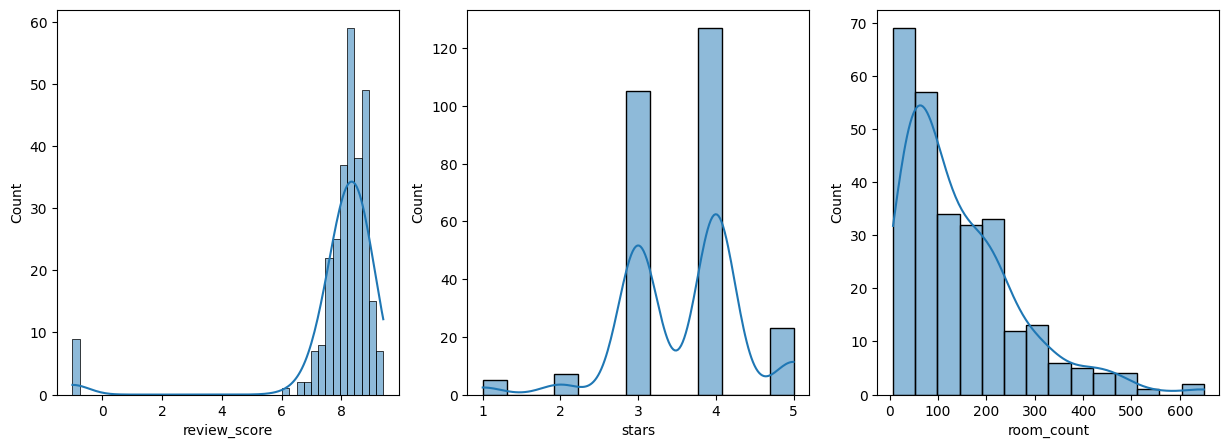

In [305]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
sns.histplot(hotel_information.review_score, kde=True, ax=ax[0])
sns.histplot(hotel_information.stars, kde=True, ax=ax[1])
sns.histplot(hotel_information.room_count, kde=True, ax=ax[2])

<Axes: xlabel='review_score', ylabel='Count'>

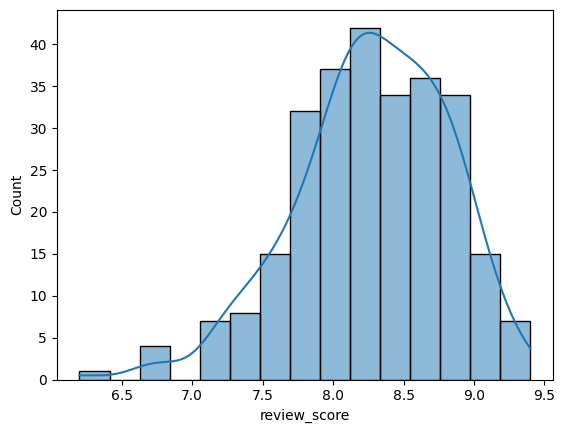

In [306]:
review_score_5 = hotel_information[hotel_information['review_score'] > 5]
sns.histplot(review_score_5.review_score, kde=True)

In [307]:
hotel_information[hotel_information['review_score'] < 5]

,our_hotel_id,name,review_score,stars,latitude,longitude,room_count
28,3224920,Acostar Hotel,-1.0,NaN,52.365244,4.885768,30.0
40,3170500,Brussels Marriott Hotel Grand Place,-1.0,NaN,50.848711,4.348075,221.0
73,3169760,Holiday Inn Brussels Schuman,-1.0,NaN,50.840725,4.383821,62.0
105,3169580,Hotel Novotel Brussels Off Grand Place,-1.0,NaN,50.846304,4.354979,140.0
161,3169520,NH Brussels Bloom,-1.0,NaN,50.855168,4.366521,305.0
182,3162240,Rokin Hotel,-1.0,NaN,52.370629,4.892961,38.0
203,3162060,Hotel Asterisk 3 star superior,-1.0,NaN,52.358835,4.893867,40.0
208,17975980,Holiday Inn Express - Brussels - Grand-Place,-1.0,NaN,50.851797,4.350214,117.0
278,3169400,Thon Hotel Bristol Stephanie,-1.0,NaN,50.831528,4.358980,142.0


### Location

In [308]:
mean_lat = hotel_information.latitude.mean()
mean_lng = hotel_information.longitude.mean()

_map = folium.Map(location=[mean_lat, mean_lng], zoom_start=8)
for lat, lon in zip(hotel_information.latitude,hotel_information.longitude):
    folium.CircleMarker([lat,lon],color='red', radius =3).add_to(_map)
_map

### Findings

* Few hotels have negative score. Reviews have a left-skewed distribution
* Hotels with negative score does not have stars, meaning that the negative score may mean 'False' (-1) in the origins base
* Most hotels has 3 or 4 stars
* Room count follows a descent tendency, right-skewed, as expected. It is easier to have less rooms in a hotel
* Two Markets: Brussels and Amsterdam. There are city centre and outside city centre hotels

## Pricing Data

### Number of lines

In [309]:
pricing_data.shape

(25380, 9)

### NAs (%)

In [310]:
round(1- pricing_data.count()/pricing_data.shape[0],3)*100

our_hotel_id            0.0
arrival_date            0.0
lead_time               0.0
room_name              10.3
meal_type_included     10.3
max_persons            10.3
price_value_ref        11.0
price_value_non_ref    10.3
is_sold_out             0.0
dtype: float64

In [311]:
pricing_data[pricing_data.room_name.isna()]['is_sold_out'].value_counts()

is_sold_out
True    2624
Name: count, dtype: int64

In [312]:
pricing_data[pricing_data.price_value_ref.isna()]['is_sold_out'].value_counts()

is_sold_out
True     2624
False     159
Name: count, dtype: int64

In [313]:
pricing_data[(pricing_data.price_value_ref.isna()) & (pricing_data.is_sold_out == False)].head()

,our_hotel_id,arrival_date,lead_time,room_name,meal_type_included,max_persons,price_value_ref,price_value_non_ref,is_sold_out
1260,3162115,2021-01-23,1,Deluxe Double or Twin Room,NONE,2.0,NaN,118.4,False
1261,3162115,2021-01-24,2,Deluxe Double or Twin Room,NONE,2.0,NaN,100.8,False
1262,3162115,2021-01-25,3,Deluxe Double or Twin Room,NONE,2.0,NaN,109.6,False
1263,3162115,2021-01-26,4,Deluxe Double or Twin Room,NONE,2.0,NaN,109.6,False
1264,3162115,2021-01-27,5,Deluxe Double or Twin Room,NONE,2.0,NaN,109.6,False


In [314]:
pricing_data[(pricing_data.price_value_ref.isna()) & (pricing_data.is_sold_out == False)]['our_hotel_id'].unique()

array([3162115, 3162125, 3162255, 3162265, 3162330, 3162345, 3162485,
       3162565, 3162650, 3162690, 3162770, 3162875, 3162955, 3163370,
       3169400, 3169410, 3169430, 3169435, 3169520, 3169580, 3169635,
       3169655, 3169760, 3169810, 3170390, 3170495, 3170500, 3185815,
       3386670, 3468465, 4655150, 5260685, 7638365, 8733715, 8802945,
       8870855, 9039335], dtype=int64)

### Num of distinct hotels (Double check)

In [315]:
pricing_data.our_hotel_id.nunique()

282

### Arrival Dates

In [316]:
pricing_data.arrival_date.min(), pricing_data.arrival_date.max()

('2021-01-23', '2021-04-22')

In [317]:
pricing_data[['arrival_date','lead_time']].drop_duplicates()

,arrival_date,lead_time
0,2021-01-23,1
1,2021-01-24,2
2,2021-01-25,3
3,2021-01-26,4
4,2021-01-27,5
...,...,...
85,2021-04-18,86
86,2021-04-19,87
87,2021-04-20,88
88,2021-04-21,89


### Types of rooms

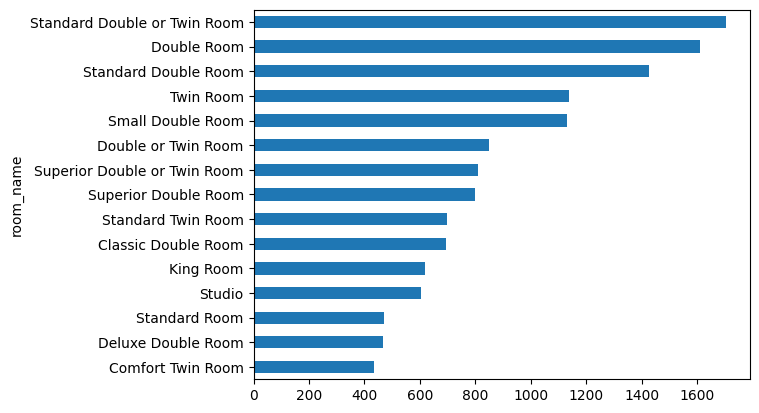

In [318]:
ax = pricing_data['room_name'].value_counts()[:15].plot(kind='barh')
ax.invert_yaxis()

In [319]:
pricing_data.groupby('our_hotel_id')['room_name'].nunique().sort_values(ascending=False)

our_hotel_id
3162060     1
3332226     1
3365792     1
3362464     1
3361471     1
           ..
3169645     1
3169704     0
3169398     0
3167784     0
17975980    0
Name: room_name, Length: 282, dtype: int64

### Meal Type

<Axes: xlabel='meal_type_included'>

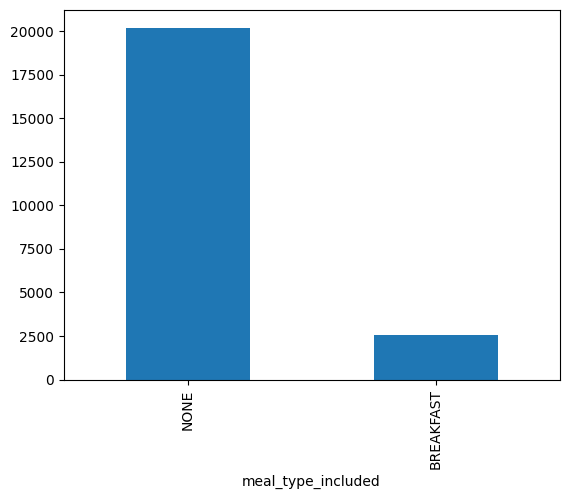

In [320]:
pricing_data.meal_type_included.value_counts().plot(kind='bar')

### Numerical Features (Lead Time, Max Persons, Price ref, Price Non Ref)

In [321]:
pricing_data.describe()

,our_hotel_id,lead_time,max_persons,price_value_ref,price_value_non_ref
count,2.538000e+04,25380.00000,22756.000000,22597.000000,22756.000000
mean,4.409062e+06,45.50000,2.003955,134.851263,116.835683
std,2.667893e+06,25.97967,0.062766,99.877643,87.140762
min,3.162060e+06,1.00000,2.000000,35.000000,8.000000
25%,3.162859e+06,23.00000,2.000000,85.000000,73.600000
50%,3.169734e+06,45.50000,2.000000,111.000000,96.000000
75%,3.691493e+06,68.00000,2.000000,152.000000,131.400000
max,1.797598e+07,90.00000,3.000000,1113.000000,890.400000


<Axes: xlabel='price_value_non_ref', ylabel='Count'>

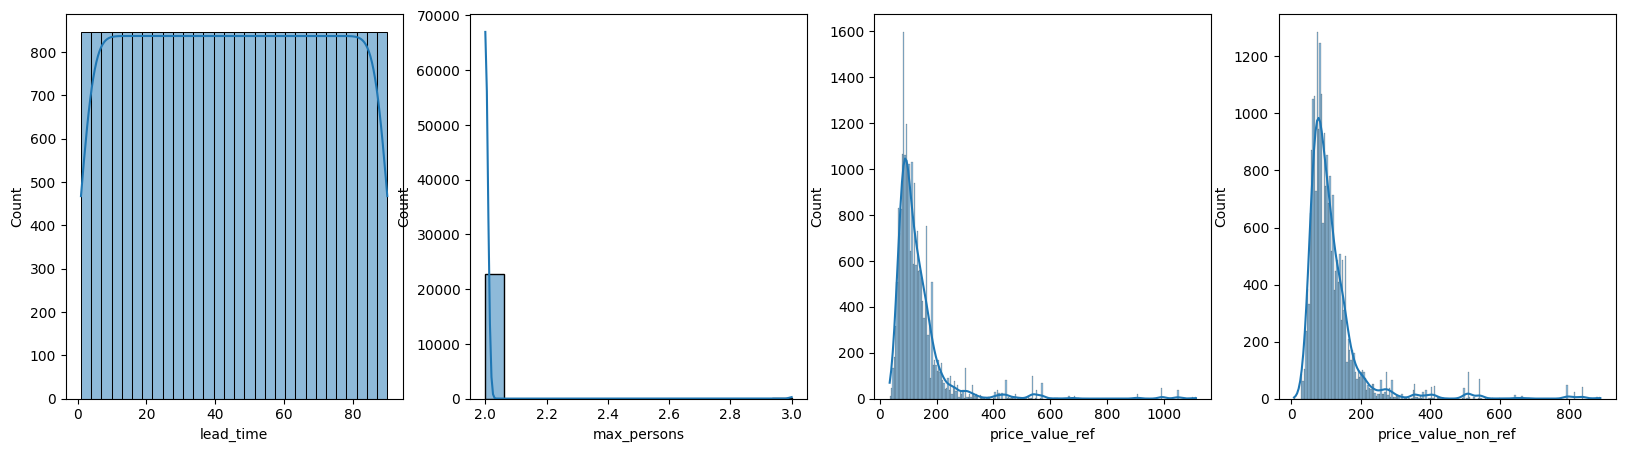

In [322]:
fig, ax = plt.subplots(1, 4, figsize=(20,5))
sns.histplot(pricing_data.lead_time, kde=True, ax=ax[0])
sns.histplot(pricing_data.max_persons, kde=True, ax=ax[1])
sns.histplot(pricing_data.price_value_ref, kde=True, ax=ax[2])
sns.histplot(pricing_data.price_value_non_ref, kde=True, ax=ax[3])

In [323]:
pricing_data[['price_value_ref','price_value_non_ref']].corr().iloc[0,1]

0.9918444029153727

c:\Users\vma_2\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



Text(0.5, 0.98, 'Price Ref & Non-ref (Correlation: 0.992)')

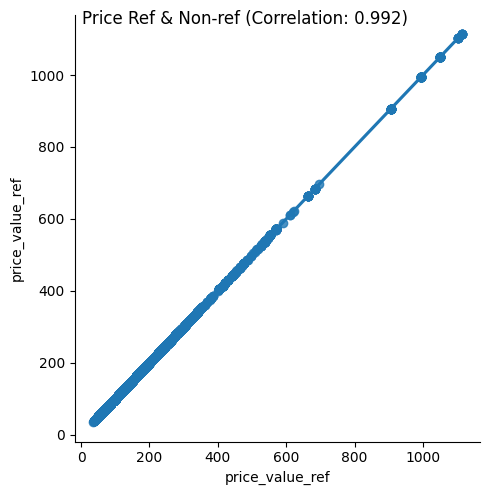

In [324]:
corr = round(pricing_data[['price_value_ref','price_value_non_ref']].corr().iloc[0,1],3)
ax = sns.lmplot(data=pricing_data, x='price_value_ref', y='price_value_ref')
ax.fig.suptitle(f'Price Ref & Non-ref (Correlation: {corr})')

<Axes: xlabel='arrival_date', ylabel='price_value_non_ref'>

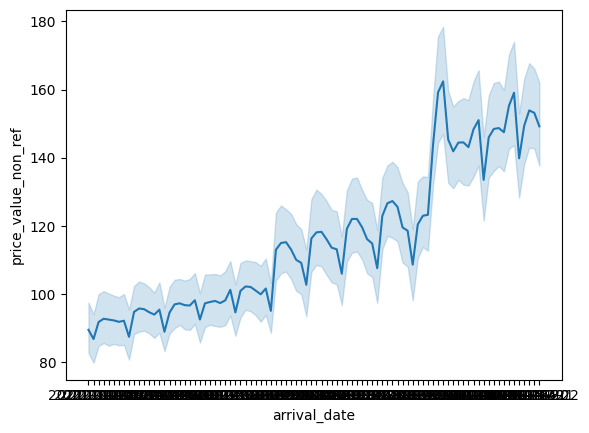

In [325]:
sns.lineplot(data=pricing_data, x='arrival_date', y='price_value_non_ref')

C:\Users\vma_2\AppData\Local\Temp\ipykernel_10764\810962261.py:3: UserWarning:


The palette list has fewer values (6) than needed (20) and will cycle, which may produce an uninterpretable plot.



<Axes: xlabel='arrival_date', ylabel='price_value_non_ref'>

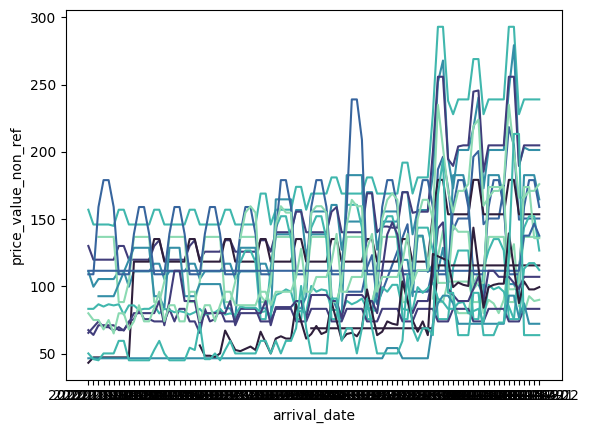

In [326]:
hotel_id_sample = random.sample(pricing_data.our_hotel_id.unique().tolist(), 20)
palette = sns.color_palette("mako_r", 6)
sns.lineplot(data=pricing_data[pricing_data['our_hotel_id'].isin(hotel_id_sample)], 
             x='arrival_date', 
             y='price_value_non_ref', 
             hue='our_hotel_id',
             palette=palette, 
             legend=False)

In [327]:
pricing_data.groupby('our_hotel_id')['lead_time'].count().value_counts()

lead_time
90    282
Name: count, dtype: int64

In [328]:
pricing_data[pricing_data.max_persons == 3]['our_hotel_id'].unique()

array([3185815], dtype=int64)

### Findings

* There are the same number of hotels in pricing base (just for checking)
* Historical of 3 months, from 2021-01-23 to 2021-04-22
* Arrival Time always have the same Lead Time in a specific date
* Each hotel uses different names for a room, but most of them hosts max 2 persons
* There is just one type of room per hotel in pricing base
* Most hotels does not have breakfast
* There is just one hotel on one room who can host max 3 persons
* Refundable price is slightly lower than non-refundable price, but they are almost perfect correlated
* As time passes, prices get higher 
* NAs:
  * Of all historical, there are about 10.3% nulls
  * Those nulls means that the hotel is sold out
  * One exception is the refundable price that has actually 0.7% of their values null. May be an error is the system? Or that means that the room is not refuldable? 

# 2. Markets Comparison

## 2.1 Split hotels in two groups

### Prepare pricing dataset

As we are joining two datasets with different granularities, we have to have sure each line of the data set correspond to the same information.

In other words, We are going to reduce pricing data set to fiil the hotels information, and use this final dataset to split into two groups

In [329]:
agg_pricing_data = pricing_data.groupby('our_hotel_id').agg(
  meal_type_included = ('meal_type_included', 'first'),
  max_persons = ('max_persons', 'mean'),
  mean_price_value_non_ref = ('price_value_non_ref', 'mean'),
  std_price_value_non_ref = ('price_value_non_ref', 'std'),
  num_sold_outs = ('is_sold_out', lambda x: (x==True).sum())
  ).reset_index().dropna()

agg_pricing_data.head()

,our_hotel_id,meal_type_included,max_persons,mean_price_value_non_ref,std_price_value_non_ref,num_sold_outs
0,3162060,NONE,2.0,131.287324,32.760391,19
1,3162064,NONE,2.0,328.490260,223.930857,13
2,3162071,NONE,2.0,88.533333,15.377556,0
3,3162083,BREAKFAST,2.0,56.320000,6.080568,0
4,3162098,BREAKFAST,2.0,127.243976,34.195027,7


NOTE: 4 hotels were 100% sold out and removed from the clustering due to being outliers, and having NAs in most columns 

In [330]:
hotel_full_information = hotel_information.merge(agg_pricing_data, how='inner', on='our_hotel_id')
hotel_full_information.head()

,our_hotel_id,name,review_score,stars,latitude,longitude,room_count,meal_type_included,max_persons,mean_price_value_non_ref,std_price_value_non_ref,num_sold_outs
0,3169410,Hotel Indigo Brussels - City,8.4,4.0,50.855711,4.359679,283.0,NONE,2.0,109.366667,18.901645,0
1,3162064,Facade Hotel Amsterdam,7.6,2.0,52.374966,4.899320,30.0,NONE,2.0,328.490260,223.930857,13
2,8482738,Chasse Hotel,8.7,4.0,52.369583,4.861395,37.0,NONE,2.0,112.224286,23.309662,20
3,3169579,Hotel Le Châtelain,8.9,5.0,50.826103,4.363769,107.0,NONE,2.0,141.777778,32.430662,0
4,3922332,The Student Hotel Amsterdam City,8.7,4.0,52.354594,4.912632,200.0,NONE,2.0,105.038333,22.477968,0


### Prepare data for clustering

In [331]:
df_model = pd.get_dummies(hotel_full_information.set_index('our_hotel_id').drop(['name'],axis=1)).drop('meal_type_included_NONE',axis=1)

In [332]:
df_model.head()

,review_score,stars,latitude,longitude,room_count,max_persons,mean_price_value_non_ref,std_price_value_non_ref,num_sold_outs,meal_type_included_BREAKFAST
our_hotel_id,,,,,,,,,,
3169410,8.4,4.0,50.855711,4.359679,283.0,2.0,109.366667,18.901645,0,False
3162064,7.6,2.0,52.374966,4.899320,30.0,2.0,328.490260,223.930857,13,False
8482738,8.7,4.0,52.369583,4.861395,37.0,2.0,112.224286,23.309662,20,False
3169579,8.9,5.0,50.826103,4.363769,107.0,2.0,141.777778,32.430662,0,False
3922332,8.7,4.0,52.354594,4.912632,200.0,2.0,105.038333,22.477968,0,False


### Inferring missing values

In [333]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

In [334]:
# Transform all negative scores into NA
df_model.loc[df_model.review_score == -1,'review_score'] = pd.NA

In [335]:
df_model[~df_model.notnull().all(1)].head()

,review_score,stars,latitude,longitude,room_count,max_persons,mean_price_value_non_ref,std_price_value_non_ref,num_sold_outs,meal_type_included_BREAKFAST
our_hotel_id,,,,,,,,,,
16424438,8.2,3.0,50.818050,4.402559,NaN,2.0,78.388889,7.562781,0,False
3224920,NaN,NaN,52.365244,4.885768,30.0,2.0,133.767808,47.670340,17,False
3170500,NaN,NaN,50.848711,4.348075,221.0,2.0,150.891667,33.175732,0,False
12112537,8.7,4.0,52.375444,4.901446,NaN,2.0,83.690000,47.040038,0,False
9590761,8.5,4.0,52.376720,4.844635,NaN,2.0,97.950000,18.179556,6,False


In [336]:
# Split dataset into full data and any NA
no_na = df_model[df_model.notnull().all(1)]
any_na = df_model[~df_model.notnull().all(1)]

In [337]:
# Apply Imputer
imputer = IterativeImputer()
imputer.fit(no_na)
df_model_imputed = pd.DataFrame(imputer.transform(df_model),index=df_model.index, columns=df_model.columns)
df_model_imputed['room_count'] = df_model_imputed['room_count'].round(0)
df_model_imputed['max_persons'] = df_model_imputed['max_persons'].round(0)
df_model_imputed.head()

,review_score,stars,latitude,longitude,room_count,max_persons,mean_price_value_non_ref,std_price_value_non_ref,num_sold_outs,meal_type_included_BREAKFAST
our_hotel_id,,,,,,,,,,
3169410,8.4,4.0,50.855711,4.359679,283.0,2.0,109.366667,18.901645,0.0,0.0
3162064,7.6,2.0,52.374966,4.899320,30.0,2.0,328.490260,223.930857,13.0,0.0
8482738,8.7,4.0,52.369583,4.861395,37.0,2.0,112.224286,23.309662,20.0,0.0
3169579,8.9,5.0,50.826103,4.363769,107.0,2.0,141.777778,32.430662,0.0,0.0
3922332,8.7,4.0,52.354594,4.912632,200.0,2.0,105.038333,22.477968,0.0,0.0


In [338]:
# Check for NAs
df_model_imputed[~df_model_imputed.notnull().all(1)].head()

,review_score,stars,latitude,longitude,room_count,max_persons,mean_price_value_non_ref,std_price_value_non_ref,num_sold_outs,meal_type_included_BREAKFAST
our_hotel_id,,,,,,,,,,


### Scaling data

In [339]:
from sklearn.preprocessing import StandardScaler

In [340]:
scaler = StandardScaler()

In [341]:
df_scaled = pd.DataFrame(scaler.fit_transform(df_model_imputed),index=df_model_imputed.index, columns=df_model_imputed.columns)

In [342]:
df_scaled.head()

,review_score,stars,latitude,longitude,room_count,max_persons,mean_price_value_non_ref,std_price_value_non_ref,num_sold_outs,meal_type_included_BREAKFAST
our_hotel_id,,,,,,,,,,
3169410,0.228438,0.560151,-1.273699,-1.310042,1.155103,-0.060084,-0.104751,-0.294363,-0.541472,-0.360668
3162064,-1.280930,-2.119805,0.804818,0.867252,-0.983152,-0.060084,2.991740,4.721776,0.322874,-0.360668
8482738,0.794451,0.560151,0.797453,0.714239,-0.923991,-0.060084,-0.064370,-0.186519,0.788292,-0.360668
3169579,1.171793,1.900129,-1.314207,-1.293539,-0.332379,-0.060084,0.353258,0.036631,-0.541472,-0.360668
3922332,0.794451,0.560151,0.776946,0.920965,0.453620,-0.060084,-0.165916,-0.206867,-0.541472,-0.360668


### Apply Clustering

In [343]:
from sklearn.cluster import KMeans

In [344]:
kmeans = KMeans(n_clusters=2, random_state=42)

In [345]:
df_scaled['group'] = kmeans.fit_predict(df_scaled)
df_model_imputed['group'] = kmeans.fit_predict(df_scaled)

df_scaled['group'] += 1
df_model_imputed['group'] += 1

c:\Users\vma_2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\vma_2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [346]:
df_model_imputed.group.value_counts()

group
1    174
2    104
Name: count, dtype: int64

In [347]:
df_radar = df_scaled.copy()
df_radar = df_radar.groupby('group').mean()

categories = df_radar.columns

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=df_radar.loc[1],
      theta=categories,
      fill='toself',
      name='Group 1'
))
fig.add_trace(go.Scatterpolar(
      r=df_radar.loc[2],
      theta=categories,
      fill='toself',
      name='Group 2'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      # range=[0, 5]
    )),
  showlegend=True,
  title=go.layout.Title(text='Comparison between group (cluster) 1 and group 2')
)

fig.show()

Points of attention in the graph above:
* Group 1 (blue) is mostly located in Amsterdam, while Group 2 (red) is located in Brussels
* Group 2 has slightly more sold out dates than Group 1
* Group 1 have hotels with higher prices (and price variation) than Group 2
* Group 2 has more sold out hotels than Group 1

<Figure size 1000x1500 with 0 Axes>

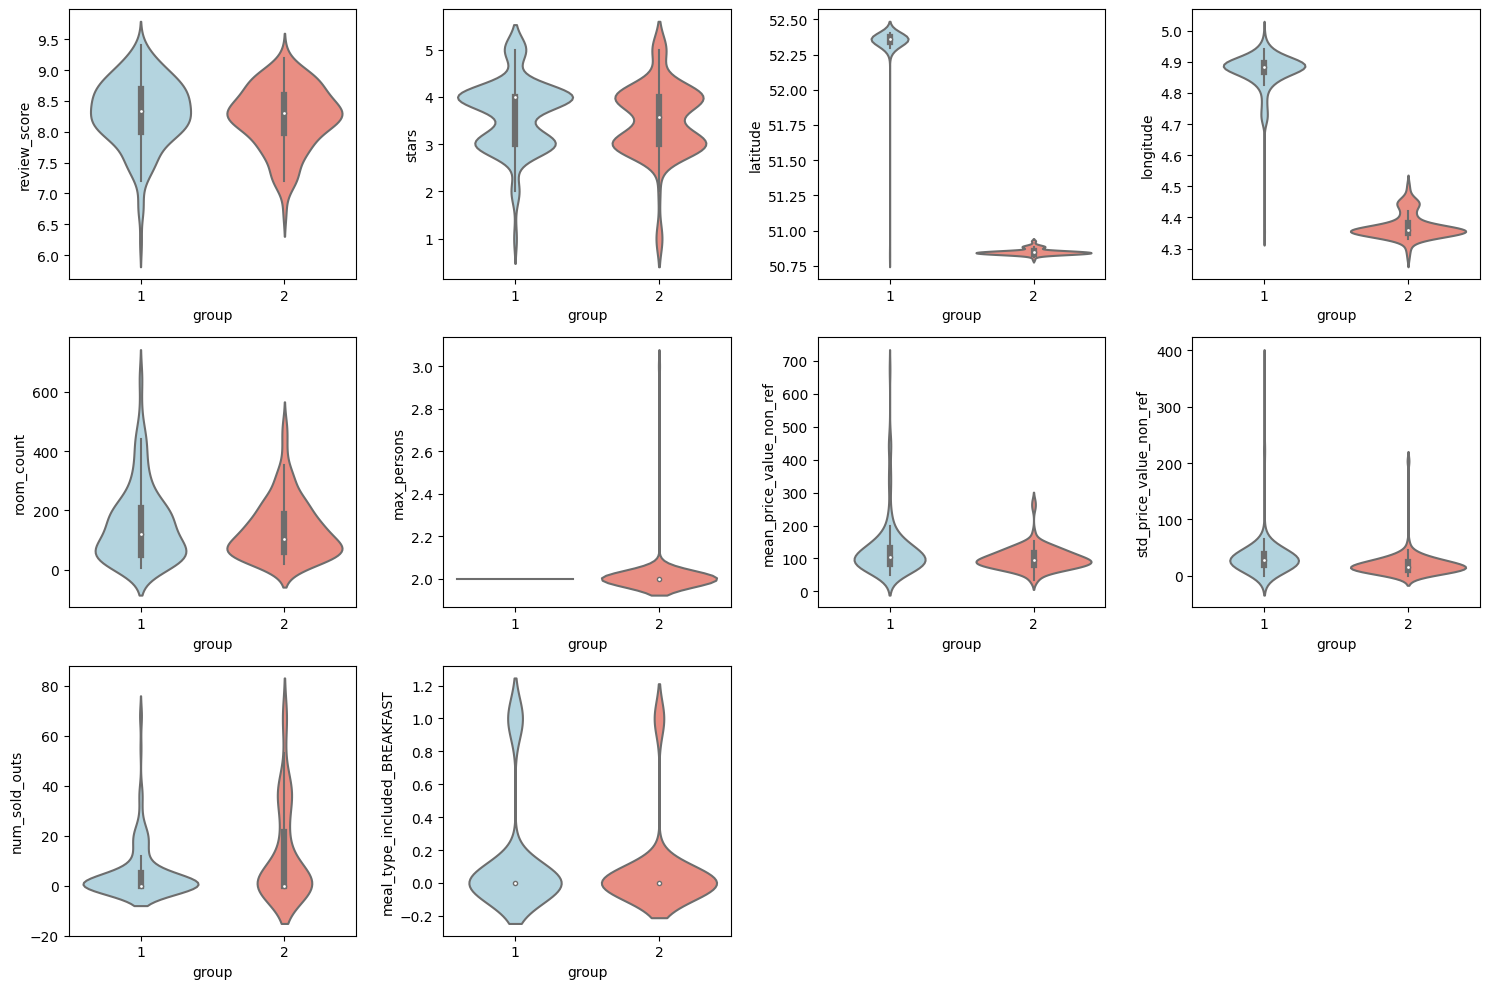

In [348]:
fig = plt.figure(figsize=(10,15))

pallete = {1: "lightblue", 2: "salmon"}

features = df_model_imputed.columns
nrows = 3
ncols = len(features[:-1])//nrows + (len(features[:-1])%nrows > 0)

fig = plt.figure(figsize=(15,10))

for i, feature in enumerate(features[:-1]):
  ax = plt.subplot(nrows, ncols, i+1)
  sns.violinplot(data=df_model_imputed, y=feature, x='group', ax=ax, palette=pallete)
  
fig.tight_layout()

In [349]:
df_map = df_model_imputed.join(hotel_full_information[['our_hotel_id','name']].set_index('our_hotel_id'),how='left')
mean_lat = df_map.latitude.mean()
mean_lng = df_map.longitude.mean()

_map = folium.Map(location=[mean_lat, mean_lng], zoom_start=8)

kclusters=2

colors_array = ['blue', 'red']


for lat, lon, name, group in zip(df_map.latitude,df_map.longitude, df_map.name, df_map.group):
    label = name
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lon],
        popup=label,
        color=colors_array[group-1],
        radius =3).add_to(_map)
_map

### Cluster data without location information

It did seems that location affects clustering, without even considering other hotel aspects, such as starts or price. We will redo the clustering, but excluding the location

In [350]:
df_no_location = df_model_imputed.copy()
df_scaled_no_location = df_scaled.copy()

cluster_data_no_location = df_scaled.drop(['latitude', 'longitude'],axis=1)

df_no_location['group'] = kmeans.fit_predict(cluster_data_no_location)
df_scaled_no_location['group'] = kmeans.fit_predict(cluster_data_no_location)

df_no_location['group'] += 1
df_scaled_no_location['group'] += 1

c:\Users\vma_2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\vma_2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [351]:
df_no_location.head()

,review_score,stars,latitude,longitude,room_count,max_persons,mean_price_value_non_ref,std_price_value_non_ref,num_sold_outs,meal_type_included_BREAKFAST,group
our_hotel_id,,,,,,,,,,,
3169410,8.4,4.0,50.855711,4.359679,283.0,2.0,109.366667,18.901645,0.0,0.0,1
3162064,7.6,2.0,52.374966,4.899320,30.0,2.0,328.490260,223.930857,13.0,0.0,2
8482738,8.7,4.0,52.369583,4.861395,37.0,2.0,112.224286,23.309662,20.0,0.0,1
3169579,8.9,5.0,50.826103,4.363769,107.0,2.0,141.777778,32.430662,0.0,0.0,1
3922332,8.7,4.0,52.354594,4.912632,200.0,2.0,105.038333,22.477968,0.0,0.0,1


In [352]:
df_no_location.group.value_counts()

group
1    269
2      9
Name: count, dtype: int64

In [353]:
df_radar = df_scaled_no_location.copy()
df_radar = df_radar.groupby('group').mean()

categories = df_radar.columns

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=df_radar.loc[1],
      theta=categories,
      fill='toself',
      name='Group 1'
))
fig.add_trace(go.Scatterpolar(
      r=df_radar.loc[2],
      theta=categories,
      fill='toself',
      name='Group 2'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      # range=[0, 5]
    )),
  showlegend=True,
  title=go.layout.Title(text='Comparison between group (cluster) 1 and group 2, without considering location')
)

fig.show()

* This time it did seems that the clustering split the data into expensive and not so expensive hotels
* Group 2 has only 9 hotels

<Figure size 1000x1500 with 0 Axes>

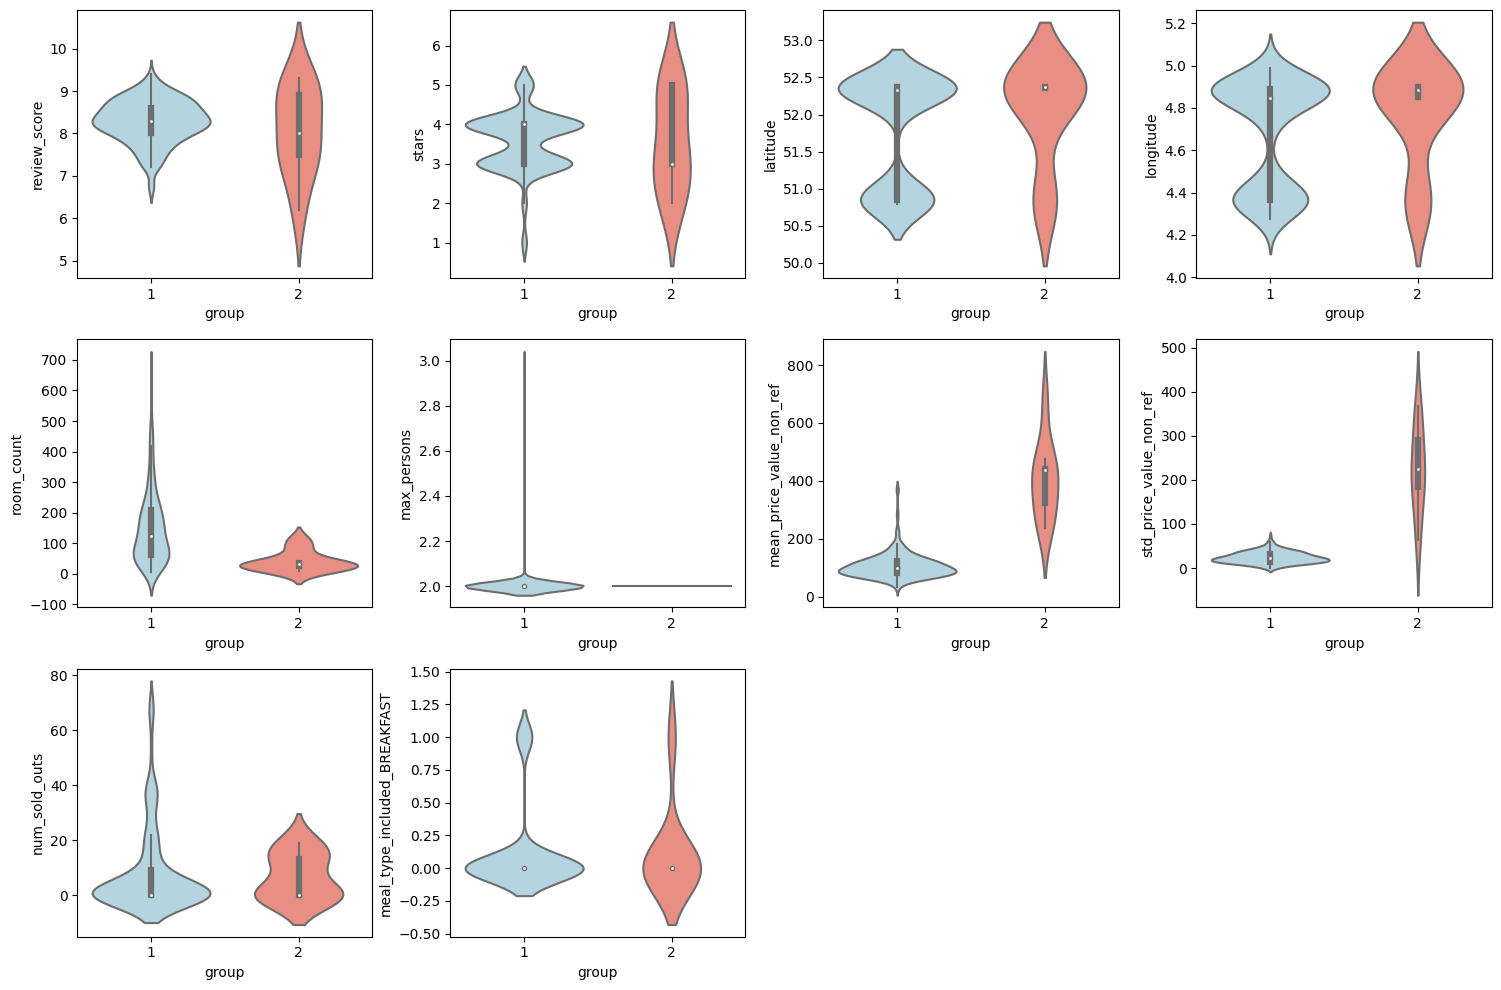

In [354]:
fig = plt.figure(figsize=(10,15))

pallete = {1: "lightblue", 2: "salmon"}
features = df_no_location.columns
nrows = 3
ncols = len(features[:-1])//nrows + (len(features[:-1])%nrows > 0)

fig = plt.figure(figsize=(15,10))

for i, feature in enumerate(features[:-1]):
  ax = plt.subplot(nrows, ncols, i+1)
  sns.violinplot(data=df_no_location, y=feature, x='group', ax=ax, palette=pallete)
  
fig.tight_layout()

In [355]:
df_map = df_no_location.join(hotel_full_information[['our_hotel_id','name']].set_index('our_hotel_id'),how='left')

mean_lat = df_map.latitude.mean()
mean_lng = df_map.longitude.mean()

_map = folium.Map(location=[mean_lat, mean_lng], zoom_start=8)

kclusters=2

colors_array = ['blue', 'red']


for lat, lon, name, group, room_count, mean_price, std_price in zip(df_map.latitude,df_map.longitude, df_map.name, df_map.group, df_map.room_count, df_map.mean_price_value_non_ref, df_map.std_price_value_non_ref):
    label = f'{name},\n Room Count:{room_count},\n Price:{round(mean_price,2)} +- {round(2*std_price,2)}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lon],
        popup=label,
        color=colors_array[group-1],
        radius =3).add_to(_map)
_map

### Cluster data removing expensive hotels

In [356]:
expensive_hotels = df_no_location[df_no_location.mean_price_value_non_ref > 200].index

In [357]:
df_no_expensive = df_model_imputed.copy().drop(expensive_hotels)
df_scaled_no_expensive = df_scaled.copy().drop(expensive_hotels)

cluster_data_no_expensive = df_scaled.drop(['latitude', 'longitude','group'],axis=1).drop(expensive_hotels)

df_no_expensive['group'] = kmeans.fit_predict(cluster_data_no_expensive)
df_scaled_no_expensive['group'] = kmeans.fit_predict(cluster_data_no_expensive)

df_no_expensive['group'] += 1
df_scaled_no_expensive['group'] += 1

c:\Users\vma_2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\vma_2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [358]:
df_no_expensive.group.value_counts()

group
1    155
2    107
Name: count, dtype: int64

In [359]:
df_radar = df_scaled_no_expensive.copy()
df_radar = df_radar.groupby('group').mean()

categories = df_radar.columns

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=df_radar.loc[1],
      theta=categories,
      fill='toself',
      name='Group 1'
))
fig.add_trace(go.Scatterpolar(
      r=df_radar.loc[2],
      theta=categories,
      fill='toself',
      name='Group 2'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      # range=[0, 5]
    )),
  showlegend=True,
  title=go.layout.Title(text='Comparison between group (cluster) 1 and group 2, without considering location')
)

fig.show()

* Group 1 now has higher stars, review score and room count
* In contrast, Group 1 also has less sold outs counts than Group 2
* Group 2 also generally has Breakfast included
* As Group 1 has more rooms, it may be correlated also to having less sold outs

<Figure size 1000x1500 with 0 Axes>

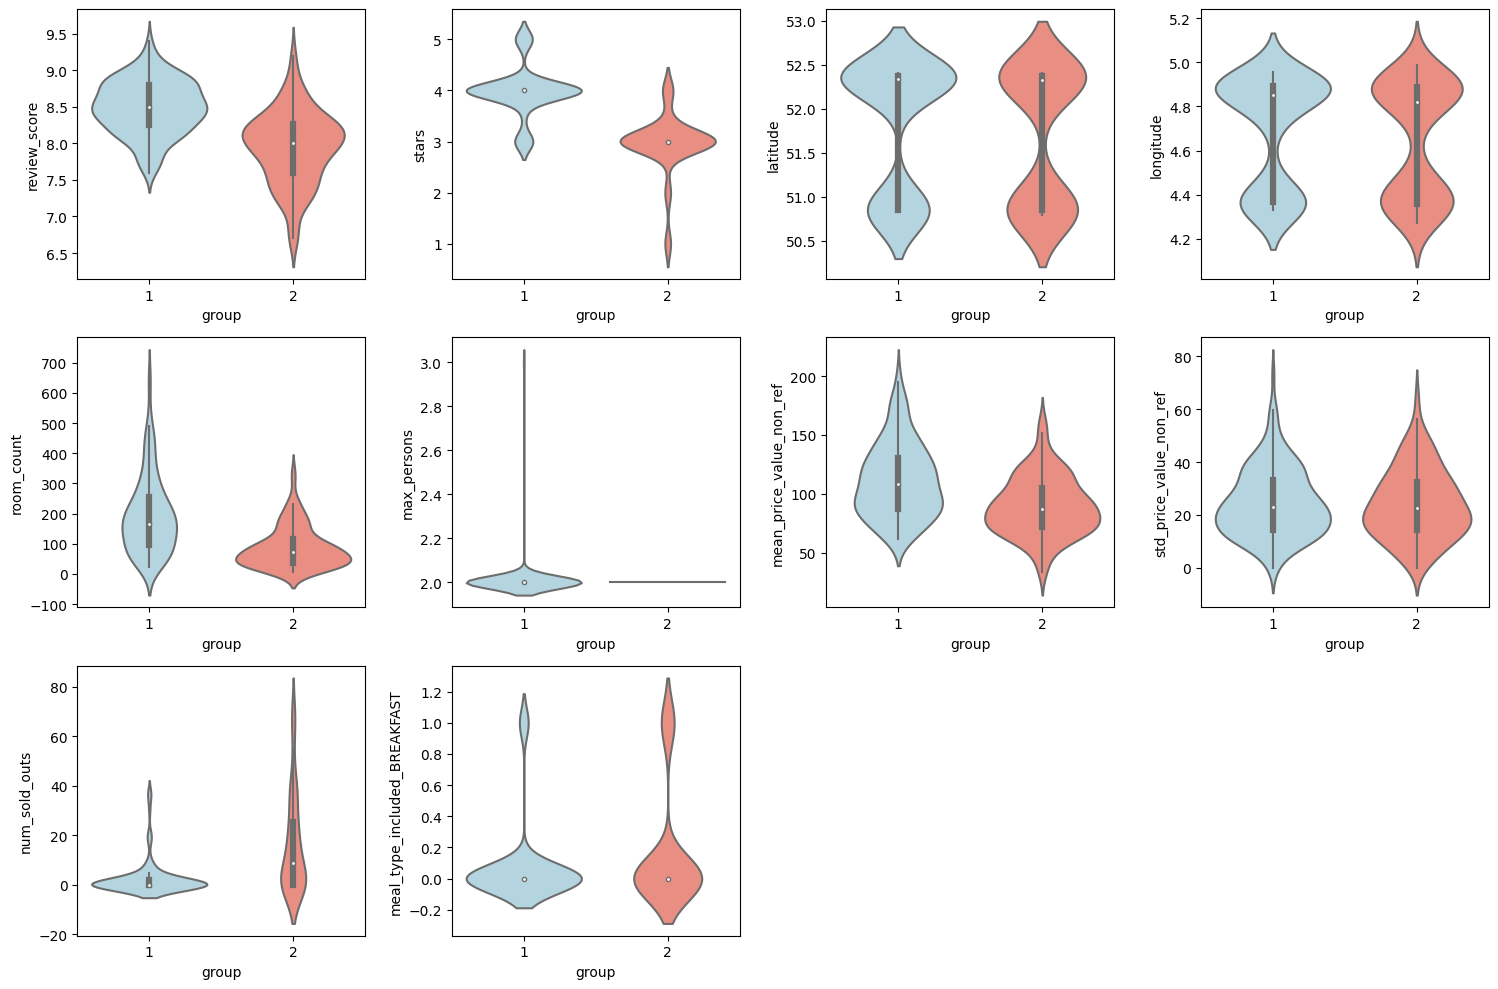

In [360]:
fig = plt.figure(figsize=(10,15))

pallete = {1: "lightblue", 2: "salmon"}
features = df_no_expensive.columns
nrows = 3
ncols = len(features[:-1])//nrows + (len(features[:-1])%nrows > 0)

fig = plt.figure(figsize=(15,10))

for i, feature in enumerate(features[:-1]):
  ax = plt.subplot(nrows, ncols, i+1)
  sns.violinplot(data=df_no_expensive, y=feature, x='group', ax=ax, palette=pallete)
  
fig.tight_layout()

In [361]:
df_map = df_no_expensive.join(hotel_full_information[['our_hotel_id','name']].set_index('our_hotel_id'),how='left')

mean_lat = df_map.latitude.mean()
mean_lng = df_map.longitude.mean()

_map = folium.Map(location=[mean_lat, mean_lng], zoom_start=8)

kclusters=2

colors_array = ['blue', 'red']


for lat, lon, name, group, room_count, mean_price, std_price in zip(df_map.latitude,df_map.longitude, df_map.name, df_map.group, df_map.room_count, df_map.mean_price_value_non_ref, df_map.std_price_value_non_ref):
    label = f'{name},\n Room Count:{room_count},\n Price:{round(mean_price,2)} +- {round(2*std_price,2)}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lon],
        popup=label,
        color=colors_array[group-1],
        radius =3).add_to(_map)
_map

## 2.2 Groups comparison

### 2.2.1 Hotel avaliability

In [362]:
# We now will join the pricing data with hotel information
comparison_data = pricing_data.merge(df_no_expensive.drop('max_persons',axis=1).reset_index(), on='our_hotel_id', how='left')
comparison_data['arrival_date'] = pd.to_datetime(comparison_data['arrival_date'])

In [363]:
avaliability = comparison_data.groupby(['group','arrival_date']).agg(num_sold_outs = ('is_sold_out', lambda x: (x==True).sum())).reset_index()

<Axes: xlabel='arrival_date', ylabel='num_sold_outs'>

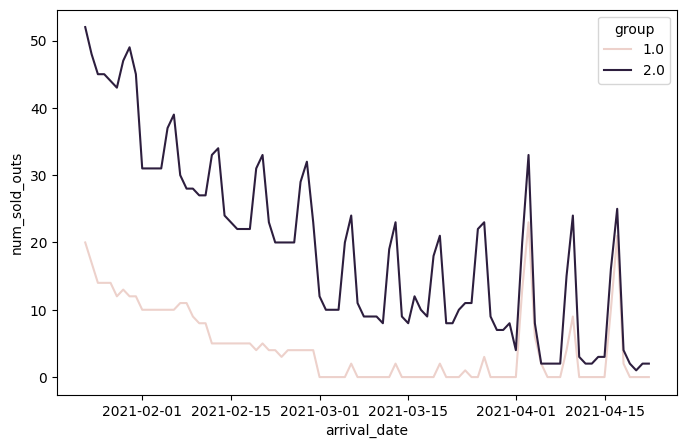

In [372]:
fig, ax = plt.subplots(figsize=(8,5))
sns.lineplot(avaliability, x='arrival_date', y ='num_sold_outs', hue='group')

#### Conclusions:
* Avaliability in both groups rises by the time, as the number of sold out hotel decreases
* For group 1, almost all hotels have avaliability from march and onwards
* Spikes may indicate weekends
* Could the hoghest spike on april indicate a holiday? Easter maybe?

### 2.2.2 Hotel prices comparison

<Axes: xlabel='arrival_date', ylabel='price_value_non_ref'>

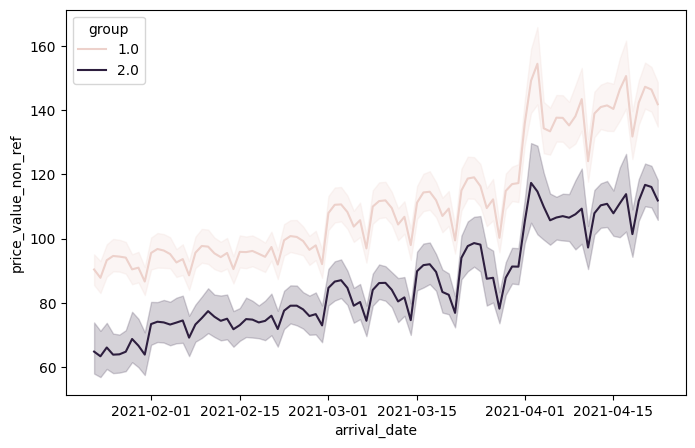

In [373]:
fig, ax = plt.subplots(figsize=(8,5))
sns.lineplot(data=comparison_data, x='arrival_date', y='price_value_non_ref', hue='group')

#### Conclusions:
* Group 1 has mean prices higher than 
* Mean prices for both groups go higher as the year goes by. Maybe it is due to end of winter?
* Mean prices does correlate inversally to the number of sold out hotels. It is possible that prices do play a important role on occupancy rate
* The data seems to have a weekly seasonality
* There is one day per week where the price is lower, except for one day, probably easter

### 2.2.3 Hotel stars and reviews comparison

<Axes: xlabel='group', ylabel='stars'>

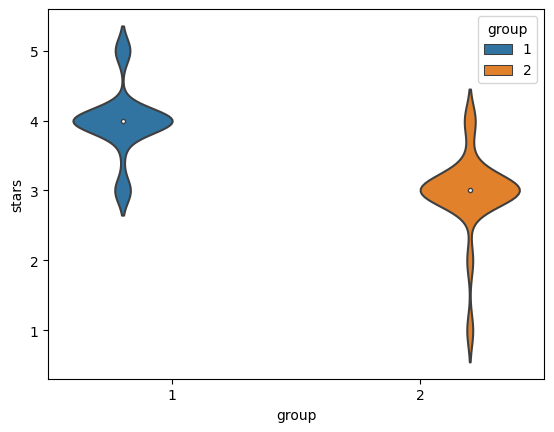

In [366]:
sns.violinplot(df_no_expensive, x='group', y='stars', hue='group')

<Axes: xlabel='group', ylabel='review_score'>

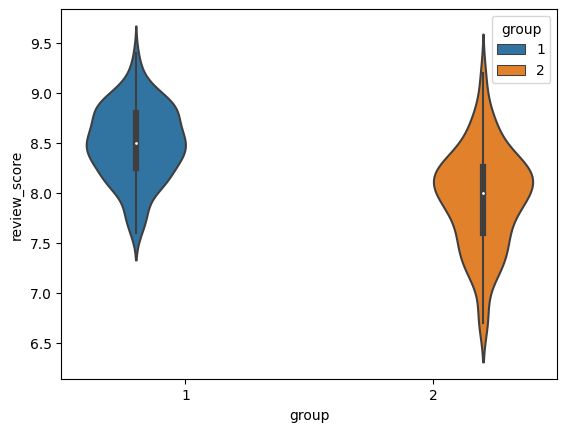

In [367]:
sns.violinplot(df_no_expensive, x='group', y='review_score', hue='group')

### 2.2.4 Other analysis

#### Price seasonality

In [384]:
decomposition_data = comparison_data.set_index('arrival_date')
decomposition_data = decomposition_data.groupby(['group','arrival_date'])['price_value_non_ref'].mean().reset_index()

decomposition_data_1 = decomposition_data[decomposition_data.group == 1].drop('group',axis=1).set_index('arrival_date')
decomposition_data_2 = decomposition_data[decomposition_data.group == 2].drop('group',axis=1).set_index('arrival_date')

In [405]:
result_1 = seasonal_decompose(decomposition_data_1, period=7)
result_2 = seasonal_decompose(decomposition_data_2, period=7)

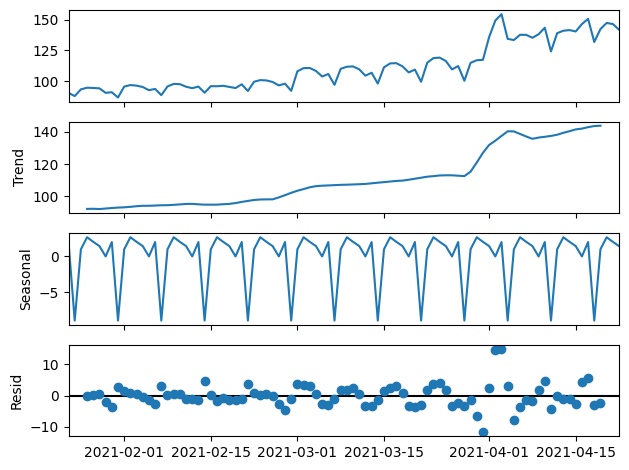

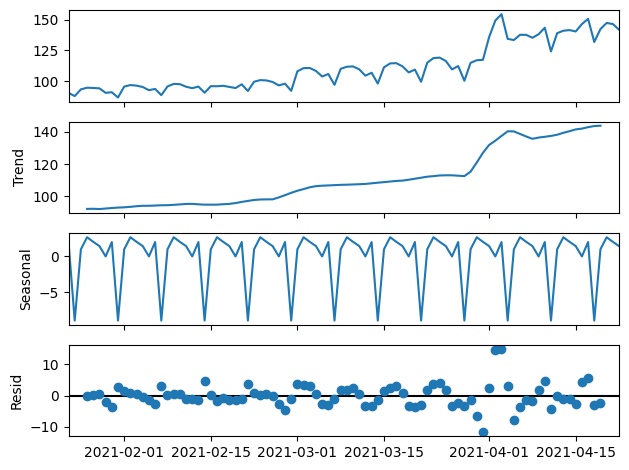

In [406]:
result_1.plot()

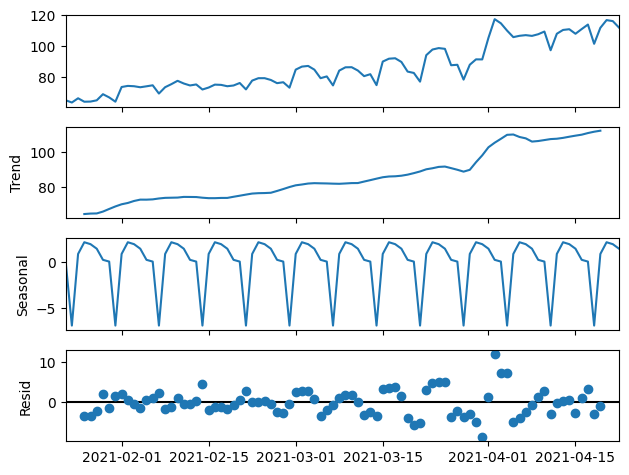

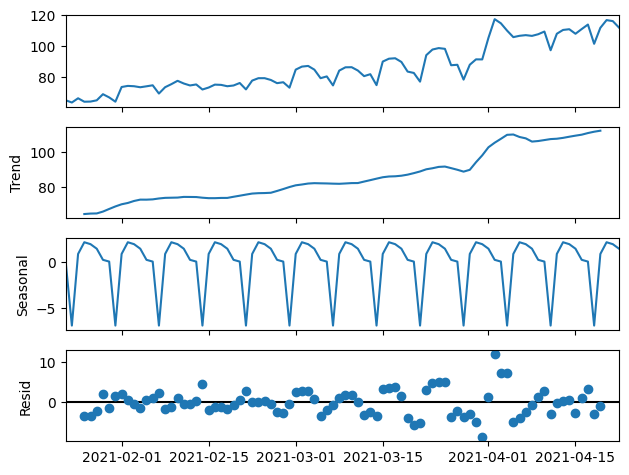

In [407]:
result_2.plot()

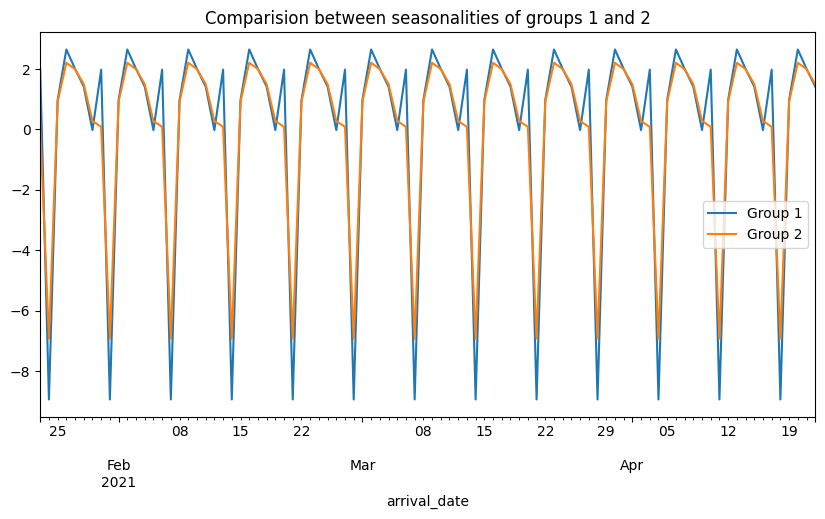

In [398]:
fig, ax = plt.subplots(figsize=(10,5))
result_1.seasonal.plot()
result_2.seasonal.plot()
plt.title('Comparision between seasonalities of groups 1 and 2')
plt.legend(['Group 1', 'Group 2'])

#### Conclusions:
* Sunday is the best day to book a hotel, while tuesday is the worse
* For Group 2, after Tuesday, the prices get lower up to Sunday
* One big difference from Group 1 and 2 is that Saturday is a bad day to book a hotel for Group 1